In [247]:
import torch
import numpy as np
from pandas import DataFrame
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from torch.autograd import Variable

# K means 

Implement K means with Pytorch.

In [311]:
def k_means(X,n_clusters = 3, n_iterations = 100):
    x = torch.from_numpy(X)
    n_data_points = x.size()[0]
    dimension = x.size()[1]
    centers = torch.randn([n_clusters,dimension],dtype = torch.double)
    print(centers)

    for _ in range(n_iterations):
        #calculate distances from each center
        dist=torch.stack([torch.norm(x - cluster.repeat(n_data_points,1),p =2, dim = 1) for cluster in centers])

        #assignment
        arg_min = torch.argmin(dist,dim=0,keepdim= True)
        one_hot = torch.zeros(n_clusters,n_data_points)
        one_hot = one_hot.scatter_(0, arg_min, torch.ones(arg_min.size()))

        #update centers
        normalize = torch.tensor([1/max(row.sum(),1) for row in one_hot])
        normalize = torch.diag(normalize)
        centers = torch.mm(normalize,torch.mm(one_hot,x.float())).double()

        if _%10 == 0:
            plot_current(X,arg_min.reshape(-1).numpy())
            
    return [centers, arg_min]
   

def plot_current(data, label):
    df2 = DataFrame(dict(x=data[:,0], y=data[:,1], label=label))
    colors = {0:'red', 1:'blue',2:'green'}
    fig, ax = plt.subplots()
    grouped = df2.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()


make_moons data set

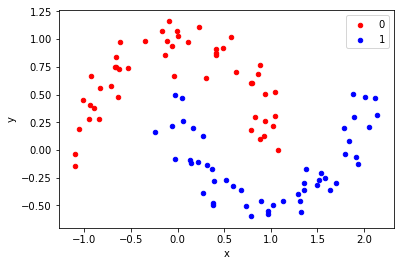

tensor([[-0.2160, -0.1332],
        [-1.9858,  0.2079]], dtype=torch.float64)


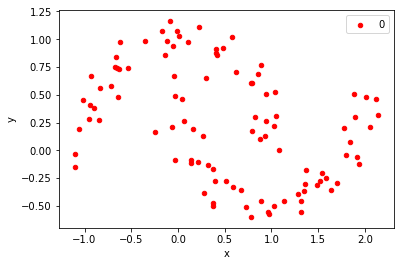

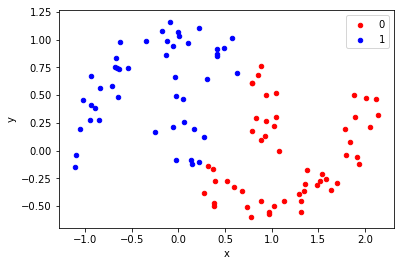

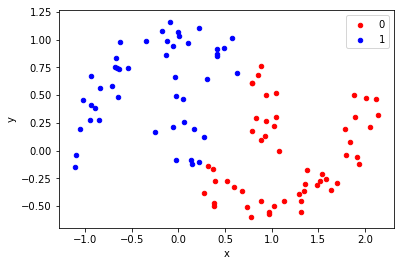

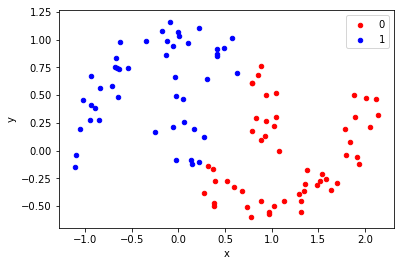

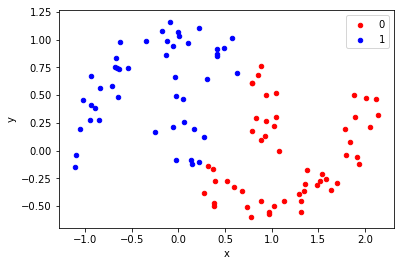

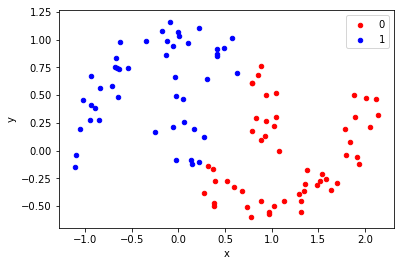

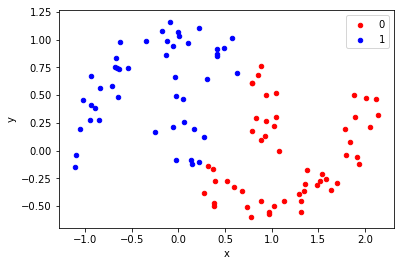

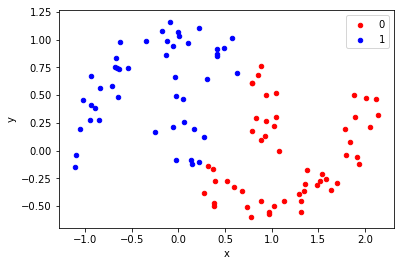

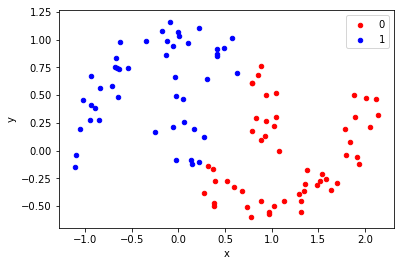

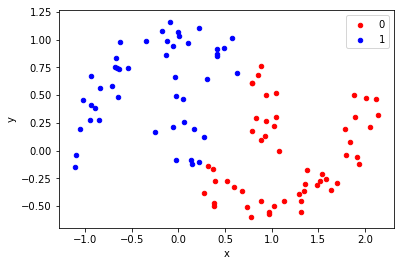

[tensor([[ 1.1715, -0.0567],
         [-0.2459,  0.5787]], dtype=torch.float64),
 tensor([[0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
          0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
          0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
          1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
          0, 0, 1, 1]])]

In [314]:
X,y = make_moons(n_samples = n_data_points,noise = 0.1)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

k_means(X,n_clusters = 2)

make_blobs data set

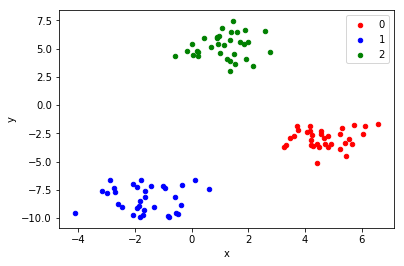

tensor([[-0.8599, -0.9032],
        [ 1.0776,  0.9336],
        [-0.9442,  0.1572]], dtype=torch.float64)


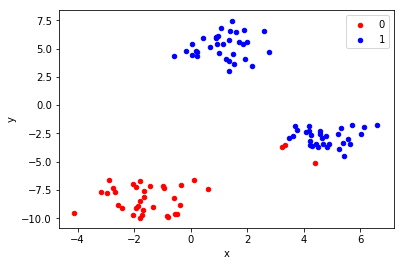

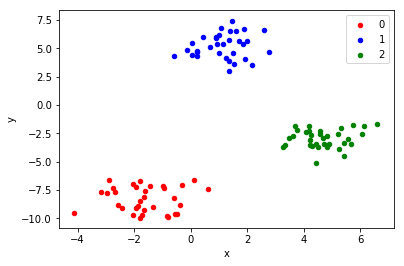

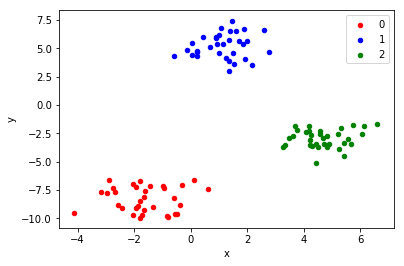

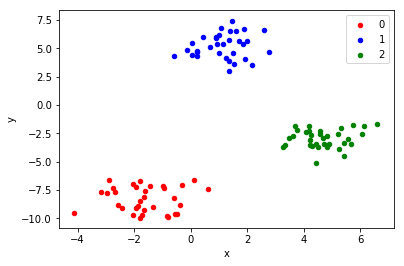

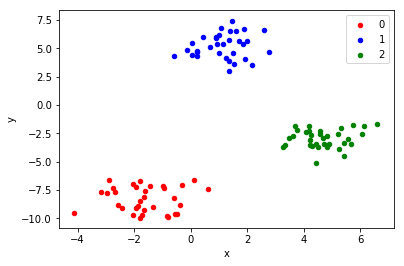

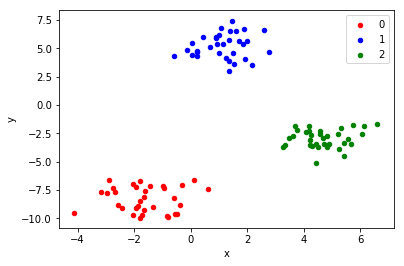

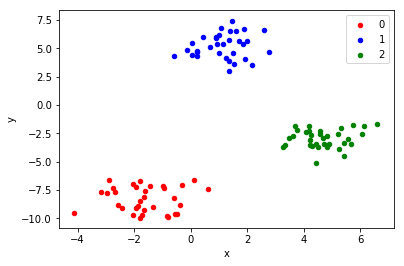

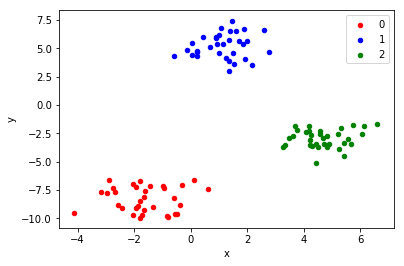

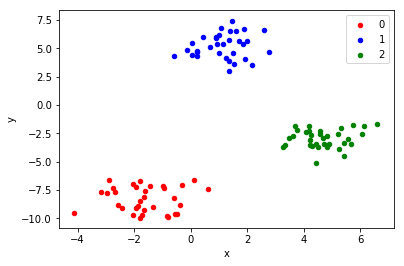

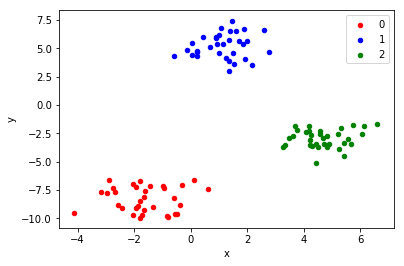

[tensor([[-1.6257, -8.3087],
         [ 1.1395,  5.1949],
         [ 4.6809, -2.9557]], dtype=torch.float64),
 tensor([[1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0,
          1, 1, 0, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
          0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0,
          1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2,
          2, 0, 0, 0]])]

In [313]:
X,y = make_blobs(n_samples = n_data_points,centers = 3)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue',2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

k_means(X,n_clusters = 3)

In [292]:
y

array([0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1,
       2, 0, 1, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2,
       0, 0, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1])